In [53]:
import os
import math
import json
import gzip
import time
import calendar
from datetime import datetime
import numpy as np
import pandas as pd
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
SETS = './sets/' # папка с файлами с наборами

In [45]:
def default_serializer(obj): # для правильного преобразования даты в ISO формат
    if isinstance(obj, (date)):
        return obj.isoformat()
    raise TypeError(f'Object of type {obj.__class__.__name__} is not JSON serializable')
    

def load_dataset(filename): 
    if os.path.exists(SETS + filename + '.gz'):
        with gzip.open(SETS + filename + '.gz', 'rb') as gzip_ref:
            return pd.DataFrame(json.load(gzip_ref))
        
    
def save_dataset(filename):
    data = globals().get(filename)
    if data is not None:
        data = data.to_dict(orient='records')
        json_data = json.dumps(data, ensure_ascii=False, default=default_serializer)
        with gzip.open(SETS + filename + '.gz', 'wb') as gzip_file:
            gzip_file.write(json_data.encode('utf-8'))
        print(f'Сохранено {len(data)} записей в {filename}.gz')

In [46]:
pd.set_option('display.max_colwidth', None) # для отображения полного текста в ячейках
pd.set_option('display.max_columns', None) 
exams_ecology = load_dataset('exams_ecology')

In [47]:
exams_ecology['year'] = pd.to_datetime(exams_ecology['start']).dt.year
exams_ecology.tail()

,global_id,start,end,stroi,roads,stupid,year
5537,2688590137,2024-03-01T00:00:00,2024-09-30T00:00:00,0.718890,0.406725,1.133333,2024
5538,2688590138,2024-03-01T00:00:00,2024-09-30T00:00:00,0.146106,0.000000,6.000000,2024
5539,2688590139,2024-03-01T00:00:00,2024-09-30T00:00:00,0.000000,0.000000,1.750000,2024
5540,2688590140,2024-03-01T00:00:00,2024-09-30T00:00:00,0.412245,0.552414,2.941176,2024
5541,2688590141,2024-03-01T00:00:00,2024-09-30T00:00:00,0.000000,0.512348,2.428571,2024


In [48]:
df = exams_ecology[['global_id', 'year', 'stroi', 'roads', 'stupid']]
X = df[['global_id', 'year', 'stroi', 'roads']]  # Признаки: год и near_stroi
y = df['stupid']  # Целевая переменная

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [32]:
model = LinearRegression()

In [33]:
model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = model.predict(X_test)

In [35]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [36]:
# Вывод метрик
print(f'Mean Squared Error: {mse:.2f}')
print(f'R²: {r2:.2f}')

Mean Squared Error: 2.07
R²: 0.01


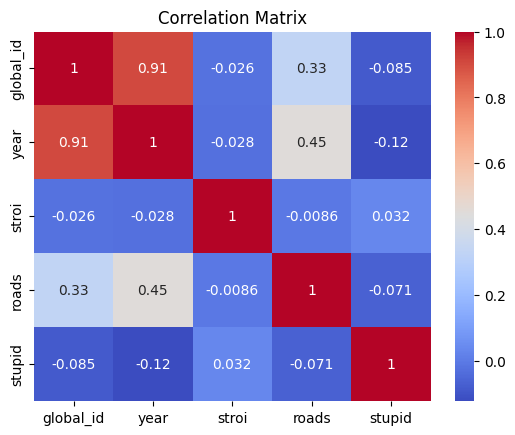

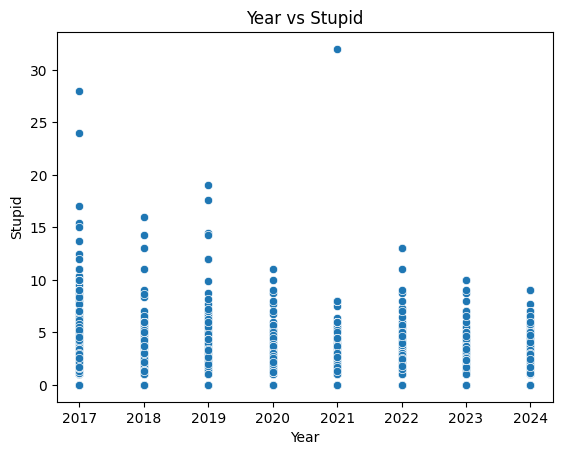

ValueError: Could not interpret value `near_stroi` for `x`. An entry with this name does not appear in `data`.

In [37]:
# Проверка корреляций
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

# Визуализация зависимости 'stupid' от 'year'
sns.scatterplot(data=df, x='year', y='stupid')
plt.title('Year vs Stupid')
plt.xlabel('Year')
plt.ylabel('Stupid')
plt.show()

# Визуализация зависимости 'stupid' от 'near_stroi'
sns.scatterplot(data=df, x='near_stroi', y='stupid')
plt.title('Near Stroi vs Stupid')
plt.xlabel('Near Stroi')
plt.ylabel('Stupid')
plt.show()

In [39]:
nn_model = MLPRegressor(hidden_layer_sizes=(100,),  # Один скрытый слой с 100 нейронами
                         activation='relu',        # Функция активации ReLU
                         solver='adam',            # Оптимизатор
                         max_iter=1000,            # Максимальное количество итераций
                         random_state=42) 

In [40]:
%%time
nn_model.fit(X_train, y_train)

CPU times: user 4.21 s, sys: 5.71 s, total: 9.92 s
Wall time: 1.3 s


MLPRegressor(max_iter=1000, random_state=42)

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)

y_pred_nn = nn_model.predict(X_test)

# Оценка модели
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'Нейронная сеть - Среднеквадратичная ошибка (MSE): {mse_nn:.2f}')
print(f'Нейронная сеть - Коэффициент детерминации (R²): {r2_nn:.2f}')

Нейронная сеть - Среднеквадратичная ошибка (MSE): 1205659102374170368.00
Нейронная сеть - Коэффициент детерминации (R²): -576564448727856384.00


In [42]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=16)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Случайный лес - Среднеквадратичная ошибка (MSE): {mse_rf:.2f}')
print(f'Случайный лес - Коэффициент детерминации (R²): {r2_rf:.2f}')

Случайный лес - Среднеквадратичная ошибка (MSE): 2.91
Случайный лес - Коэффициент детерминации (R²): -0.39


In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=16), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f'Лучший случайный лес - MSE: {mse_best_rf:.2f}')
print(f'Лучший случайный лес - R²: {r2_best_rf:.2f}')

Лучший случайный лес - MSE: 2.27
Лучший случайный лес - R²: -0.09


In [18]:
%%time
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=16)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - MSE: {mse_xgb:.2f}')
print(f'XGBoost - R²: {r2_xgb:.2f}')

XGBoost - MSE: 2.65
XGBoost - R²: -0.27
CPU times: user 717 ms, sys: 12.8 ms, total: 730 ms
Wall time: 119 ms


In [54]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Создание модели нейронной сети с большим количеством слоев
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))  # Первый скрытый слой
model.add(layers.Dense(64, activation='relu'))   # Второй скрытый слой
model.add(layers.Dense(32, activation='relu'))   # Третий скрытый слой
model.add(layers.Dense(16, activation='relu'))   # Четвертый скрытый слой
model.add(layers.Dense(8, activation='relu'))    # Пятый скрытый слой
model.add(layers.Dense(4, activation='relu'))    # Шестой скрытый слой
model.add(layers.Dense(1, activation='sigmoid'))  # Выходной слой с активацией сигмоиды

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Используется бинарная кросс-энтропия

# Обучение модели
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Оценка модели
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)  # Преобразуем вероятности в бинарные предсказания

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)

# Вывод результатов
print(f'Accuracy: {accuracy:.4f}')  # Точность предсказаний в формате 0.8 или 0.9

# Визуализация истории обучения (по желанию)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/100
111/111 [==============================] - 2s 5ms/step - loss: -196.8173 - accuracy: 0.0180 - val_loss: -1486.4772 - val_accuracy: 0.0124
Epoch 2/100
111/111 [==============================] - 0s 3ms/step - loss: -58558.5547 - accuracy: 0.0178 - val_loss: -263932.2812 - val_accuracy: 0.0124
Epoch 3/100
111/111 [==============================] - 0s 3ms/step - loss: -2150393.0000 - accuracy: 0.0178 - val_loss: -6619459.0000 - val_accuracy: 0.0124
Epoch 4/100
111/111 [==============================] - 0s 3ms/step - loss: -26695870.0000 - accuracy: 0.0178 - val_loss: -64002600.0000 - val_accuracy: 0.0124
Epoch 5/100
111/111 [==============================] - 0s 3ms/step - loss: -179867760.0000 - accuracy: 0.0178 - val_loss: -356907648.0000 - val_accuracy: 0.0124
Epoch 6/100
111/111 [==============================] - 0s 3ms/step - loss: -799345216.0000 - accuracy: 0.0178 - val_loss: -1401422208.0000 - val_accuracy: 0.0124
Epoch 7/100
111/111 [==============================] - 0s

111/111 [==============================] - 0s 2ms/step - loss: -619132689055744.0000 - accuracy: 0.0178 - val_loss: -631849684566016.0000 - val_accuracy: 0.0124
Epoch 50/100
111/111 [==============================] - 0s 3ms/step - loss: -688895104647168.0000 - accuracy: 0.0178 - val_loss: -701989923061760.0000 - val_accuracy: 0.0124
Epoch 51/100
111/111 [==============================] - 0s 3ms/step - loss: -764557530234880.0000 - accuracy: 0.0178 - val_loss: -778524495446016.0000 - val_accuracy: 0.0124
Epoch 52/100
111/111 [==============================] - 0s 3ms/step - loss: -846850445803520.0000 - accuracy: 0.0178 - val_loss: -860983639670784.0000 - val_accuracy: 0.0124
Epoch 53/100
111/111 [==============================] - 0s 3ms/step - loss: -935896727683072.0000 - accuracy: 0.0178 - val_loss: -950254266482688.0000 - val_accuracy: 0.0124
Epoch 54/100
111/111 [==============================] - 0s 3ms/step - loss: -1032254520295424.0000 - accuracy: 0.0178 - val_loss: -104750621759

111/111 [==============================] - 0s 2ms/step - loss: -19254963305709568.0000 - accuracy: 0.0178 - val_loss: -19122188686721024.0000 - val_accuracy: 0.0124
Epoch 96/100
111/111 [==============================] - 0s 3ms/step - loss: -20329091676766208.0000 - accuracy: 0.0178 - val_loss: -20182457198313472.0000 - val_accuracy: 0.0124
Epoch 97/100
111/111 [==============================] - 0s 3ms/step - loss: -21453353053585408.0000 - accuracy: 0.0178 - val_loss: -21289100619284480.0000 - val_accuracy: 0.0124
Epoch 98/100
111/111 [==============================] - 0s 3ms/step - loss: -22627092453654528.0000 - accuracy: 0.0178 - val_loss: -22447902123098112.0000 - val_accuracy: 0.0124
Epoch 99/100
111/111 [==============================] - 0s 3ms/step - loss: -23852051486212096.0000 - accuracy: 0.0178 - val_loss: -23667455939313664.0000 - val_accuracy: 0.0124
Epoch 100/100
35/35 [==============================] - 0s 1ms/step


ValueError: Classification metrics can't handle a mix of continuous and binary targets